In [ ]:
import numpy as np
import pandas as pd
import torch
import lightning as L
from torch import optim, nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
import os
import logging
from wildgraph.util import dist
from mpl_toolkits.mplot3d import Axes3D  
import csv



class VAERunner:
    def __init__(self, seq_len, test_sample_size):
        self.seq_len = seq_len
        self.test_sample_size = test_sample_size

    def run_vae(self, df_train, df_test, epochs):
        # Grouper les données par 'id' et 'label' : un id désigne un joueur, un label désigne un type de session (0 = uniform, 1 = patchy)
        grouped = df_train.groupby(['id', 'label'])
        group_arrays = [group[['x', 'y']].to_numpy() for _, group in grouped]
        original_labels = [label for (_, label), _ in grouped]
        
        # Pad ou tronquer les trajectoires à une longueur fixe
        train_array = np.array([pad_or_truncate(traj, self.seq_len) for traj in group_arrays])
        
        dataset = VAEDataset(train_array)
        train_loader = DataLoader(dataset, batch_size=8, num_workers=8)
        
        autoencoder = LitAutoEncoder(self.seq_len)
        trainer = L.Trainer(max_epochs=epochs, devices=1)
        trainer.fit(autoencoder, train_loader)
        autoencoder.encoder.eval()

        # Encoder les données d'entraînement
        x = torch.tensor(train_array)
        x = x.view(x.size(0), -1)
        encoded_data = autoencoder.encoder(x.float()).detach().cpu().numpy()

        # Ajuster un GMM sur les données encodées
        gmm = GaussianMixture(n_components=4)  
        gmm.fit(encoded_data)
        labels = gmm.predict(encoded_data) 

        # Générer des échantillons aléatoires à partir du GMM
        random_samples, _ = gmm.sample(self.test_sample_size)
        random_samples = torch.from_numpy(random_samples).float()

        # Décoder 
        generated = autoencoder.decoder(random_samples).detach().cpu().numpy()
        generated = generated.reshape(self.test_sample_size, self.seq_len, 2)

        return encoded_data, original_labels, generated, dataset, autoencoder


class VAEDataset(Dataset):
    def __init__(self, df, tokenizer=None):
        self.data = df
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx]).float()

# Define the VAE model 
class LitAutoEncoder(L.LightningModule):
    def __init__(self, seq_length):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(seq_length*2, 32), nn.ReLU(), nn.Linear(32, 3))
        self.decoder = nn.Sequential(nn.Linear(3, 32), nn.ReLU(), nn.Linear(32, seq_length*2))
        self.gmm = GaussianMixture(n_components=3)
        self.hausdorff = dist.Hausdorff()
        self.dtw = dist.DTW()
        self.fde = dist.FDE()

    def training_step(self, batch, batch_idx):
        x = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = nn.functional.mse_loss(x_hat, x)

        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

def prepare_data(df, seq_len):
    grouped = df.groupby(['id', 'label'])
    group_arrays = [group[['x', 'y']].to_numpy() for _, group in grouped]
    train_array = np.array([pad_or_truncate(traj, seq_len) for traj in group_arrays])
    return train_array


# Function to visualize the latent space
def plot_latent_space(encoded_data, original_labels, reduce_dim=True):
    """
    Plot the latent space in 2D or 3D.
    
    Args:
        encoded_data (np.ndarray): The encoded data.
        original_labels (np.ndarray): The original labels.
        reduce_dim (bool): Whether to reduce the dimensionality to 2D using PCA
    """
    # Reduce dimensionality using PCA to make it 2D
    if reduce_dim:
        pca = PCA(n_components=2)
        latent_2d = pca.fit_transform(encoded_data)
        plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=original_labels, cmap='viridis', alpha=0.6)
        plt.colorbar(label='Cluster')
        plt.xlabel('Latent Dimension 1')
        plt.ylabel('Latent Dimension 2')
        plt.title('Latent Space Visualization')
        plt.show()
    else:  # 3D plot else 
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        # Scatter plot in 3D
        scatter = ax.scatter(
            encoded_data[:, 0],  
            encoded_data[:, 1],  
            encoded_data[:, 2],  
            c=original_labels,            
            cmap='viridis',      
            alpha=0.6,           
            s=50                 
        )
        cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
        cbar.set_label('Original labels (0 = uniform, 1 = patchy)')

        ax.set_xlabel('Latent Dimension 1')
        ax.set_ylabel('Latent Dimension 2')
        ax.set_zlabel('Latent Dimension 3')
        ax.set_title('3D Latent Space Visualization')
        plt.show()

    

# Load the dataset
def load_data(file_path):
    df = pd.read_csv(file_path, usecols=['id', 'x', 'y', 'label'])
    return df

def pad_or_truncate(trajectory, seq_len):
    """
    Pad or truncate a trajectory to a fixed length.

    Args:
        trajectory (np.ndarray): The trajectory as a NumPy array of shape (n, 2).
        seq_len (int): The desired fixed length.

    Returns:
        np.ndarray: The padded or truncated trajectory of shape (seq_len, 2).
    """
    if len(trajectory) > seq_len:
        # Truncate the trajectory
        return trajectory[:seq_len]
    else:
        # Pad the trajectory with the last point
        padding = np.tile(trajectory[-1], (seq_len - len(trajectory), 1))
        return np.vstack([trajectory, padding])




/home/ensta/ensta-kupecek/.conda/envs/wildgraph/lib/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/ensta/ensta-kupecek/.conda/envs/wildgraph/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ensta/ensta-kupecek/.conda/envs/wildgraph/lib/ ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ensta/ensta-kupecek/.conda/envs/wildgraph/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reaso

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=90` reached.


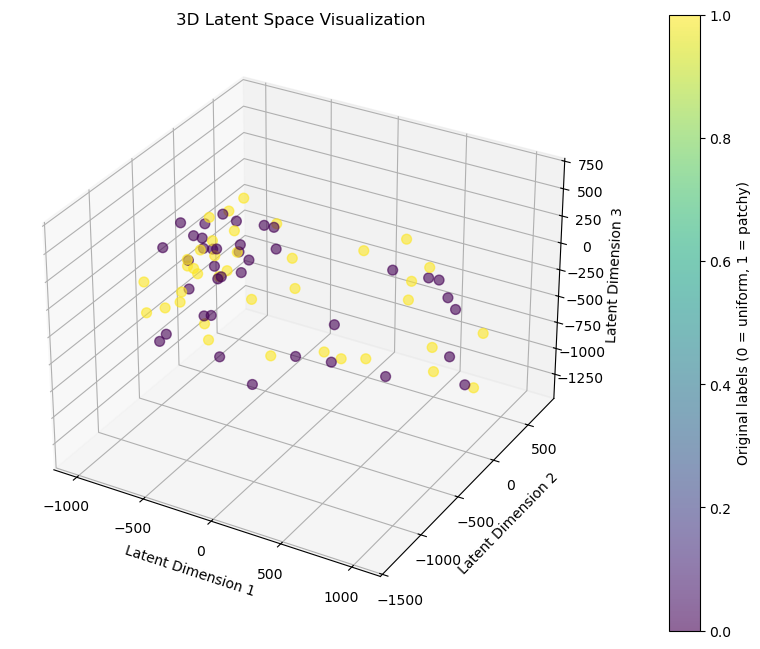

Generated trajectories saved to ./vae_experiments/generated_trajectories.npy


In [3]:
    # Load the dataset
file_path = "merged.csv"  # Update this path to your dataset
df = load_data(file_path)


    # Initialize the VAE runner
seq_len = 400  
test_sample_size = 39  # We try to generate as much samples as we have in the original dataset
runner = VAERunner(seq_len, test_sample_size)

    # Run the VAE
encoded_data, original_labels, generated, dataset, autoencoder = runner.run_vae(df, df, epochs=90)

    # Visualize the latent space
plot_latent_space(encoded_data, original_labels, reduce_dim=False)

    # Save the generated trajectories
save_dir = "./vae_experiments/"
os.makedirs(save_dir, exist_ok=True)
np.save(f"{save_dir}generated_trajectories.npy", generated)
print(f"Generated trajectories saved to {save_dir}generated_trajectories.npy")


## Plot some generated  trajectories

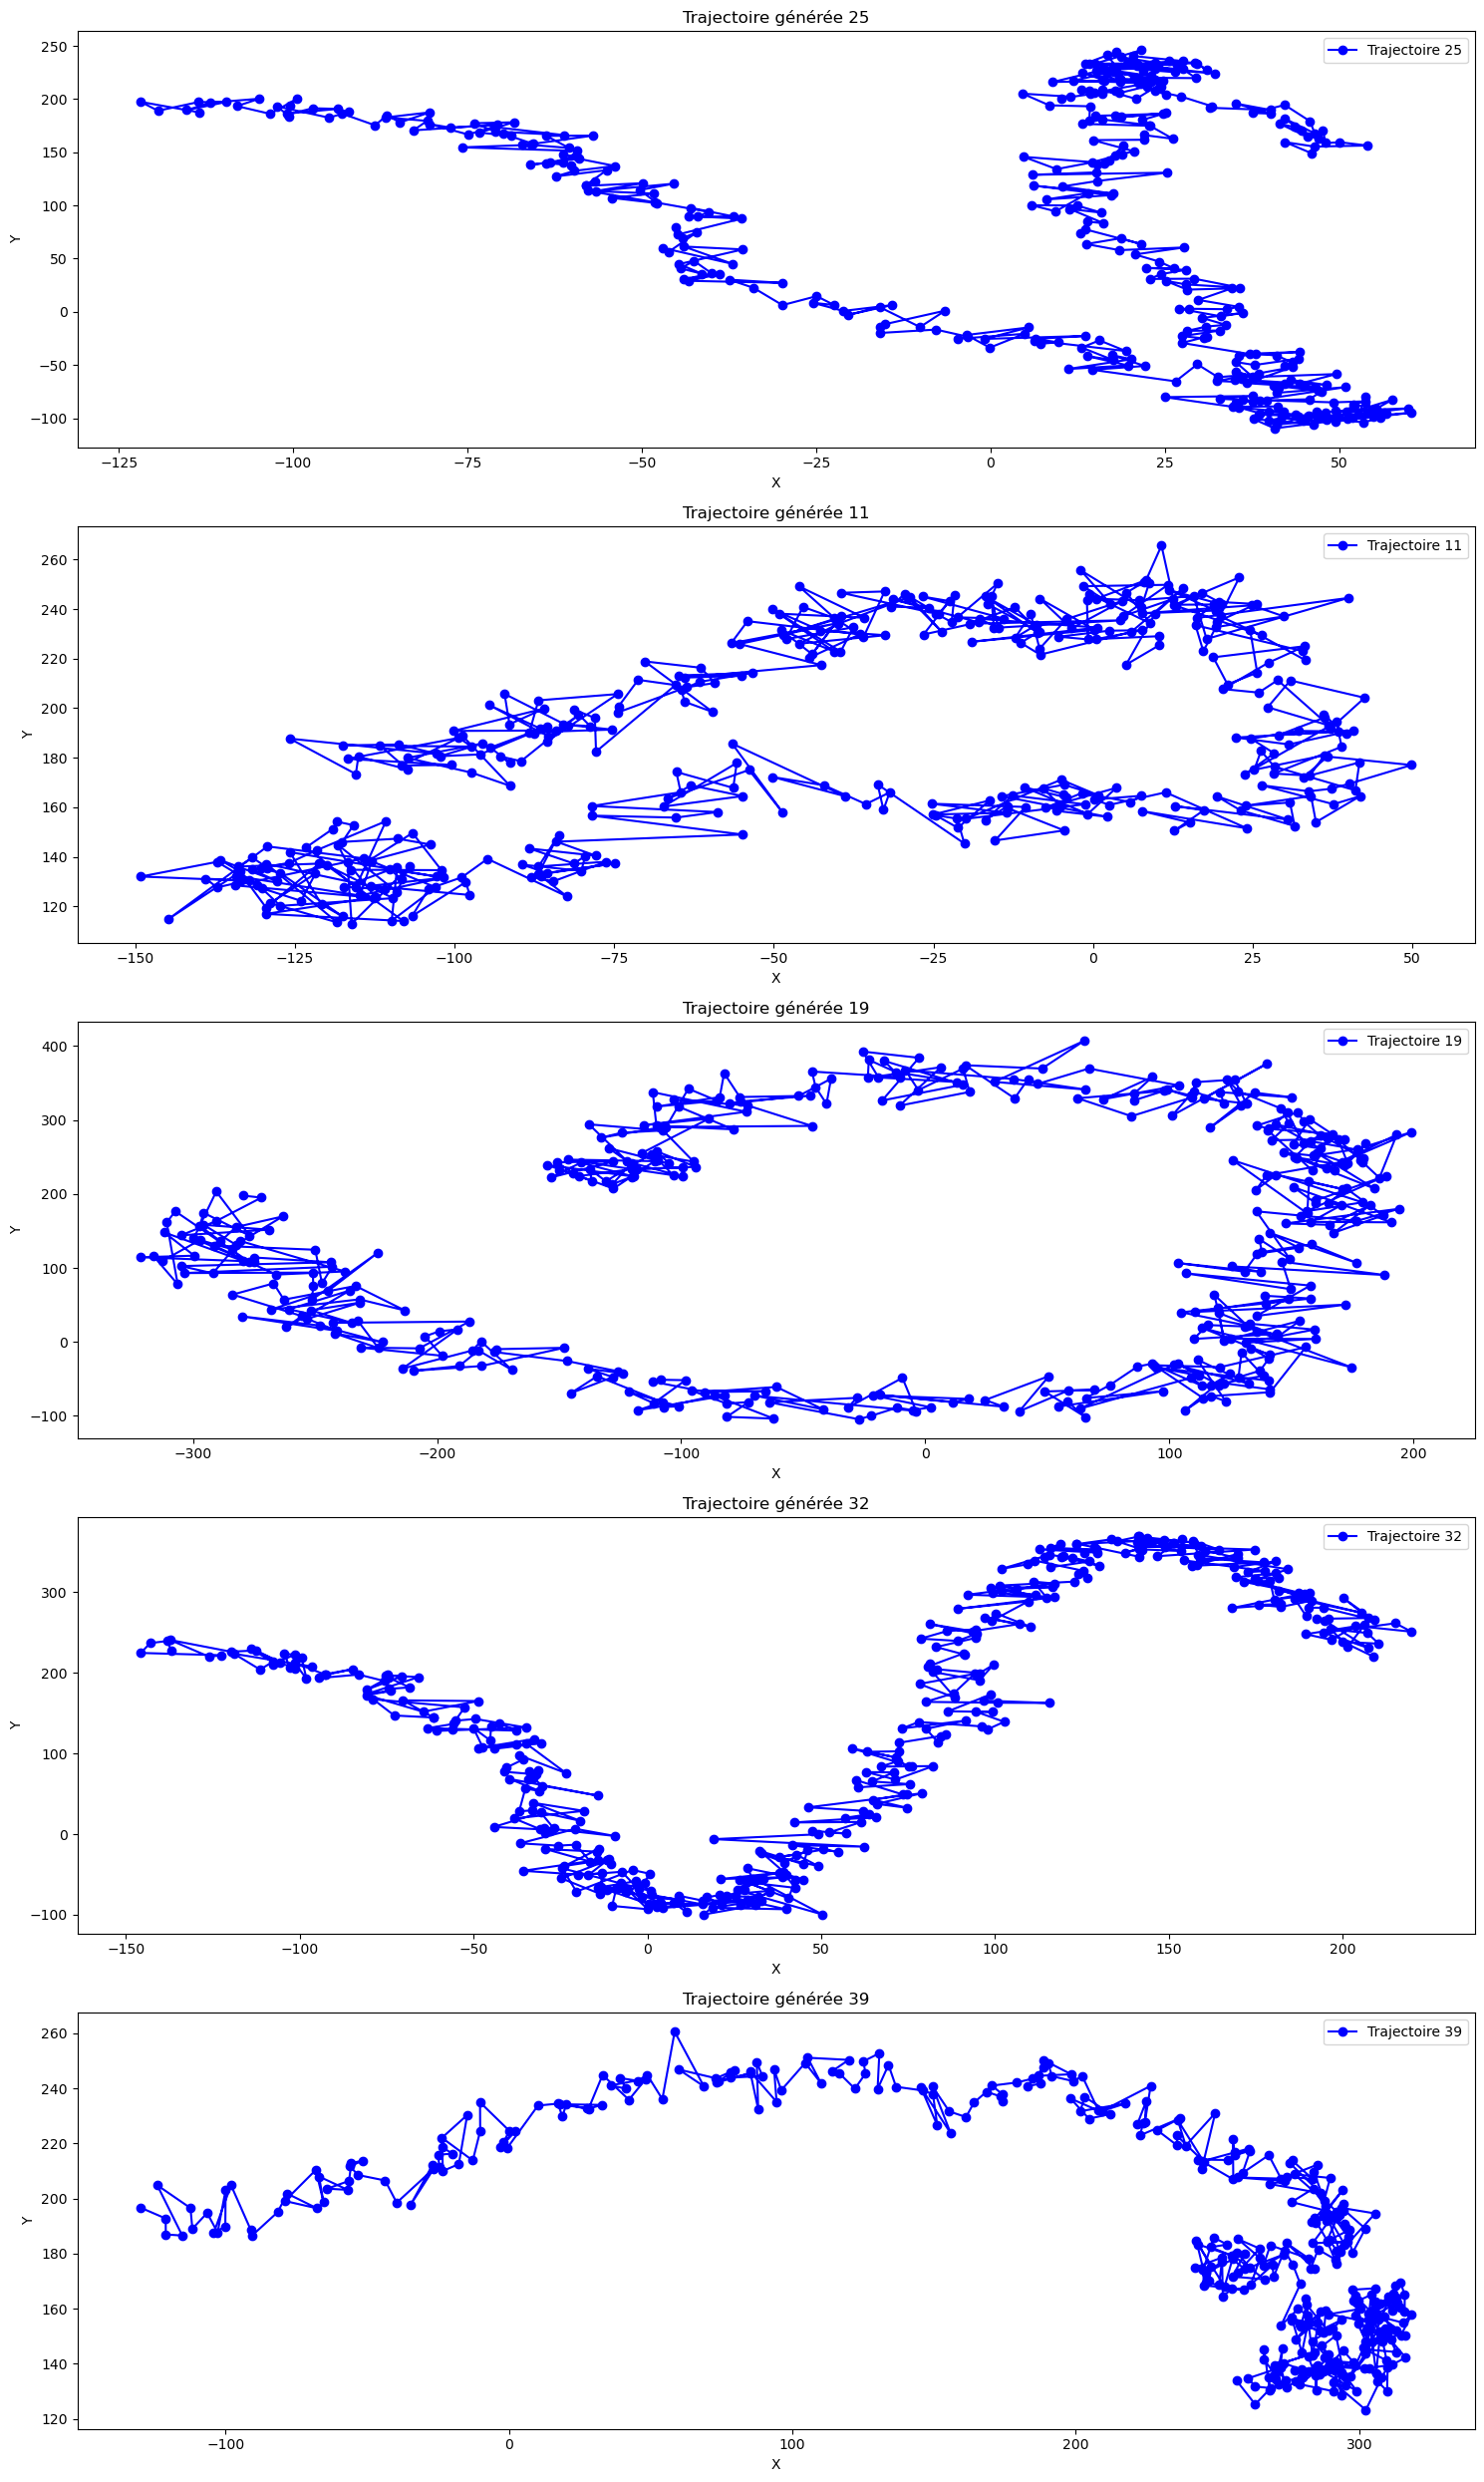

In [18]:
plt.figure(figsize=(15, 5 * 5)) 
random_indices = np.random.choice(test_sample_size, size=5, replace=False)

for idx, i in enumerate(random_indices):
    plt.subplot(5, 1, idx + 1) 
    plt.plot(generated[i][:, 0], generated[i][:, 1], 'b-o', label=f'Trajectoire {i + 1}')
    plt.title(f'Trajectoire générée {i + 1}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()

plt.tight_layout()
plt.show()



### SavGol Filter smoothening

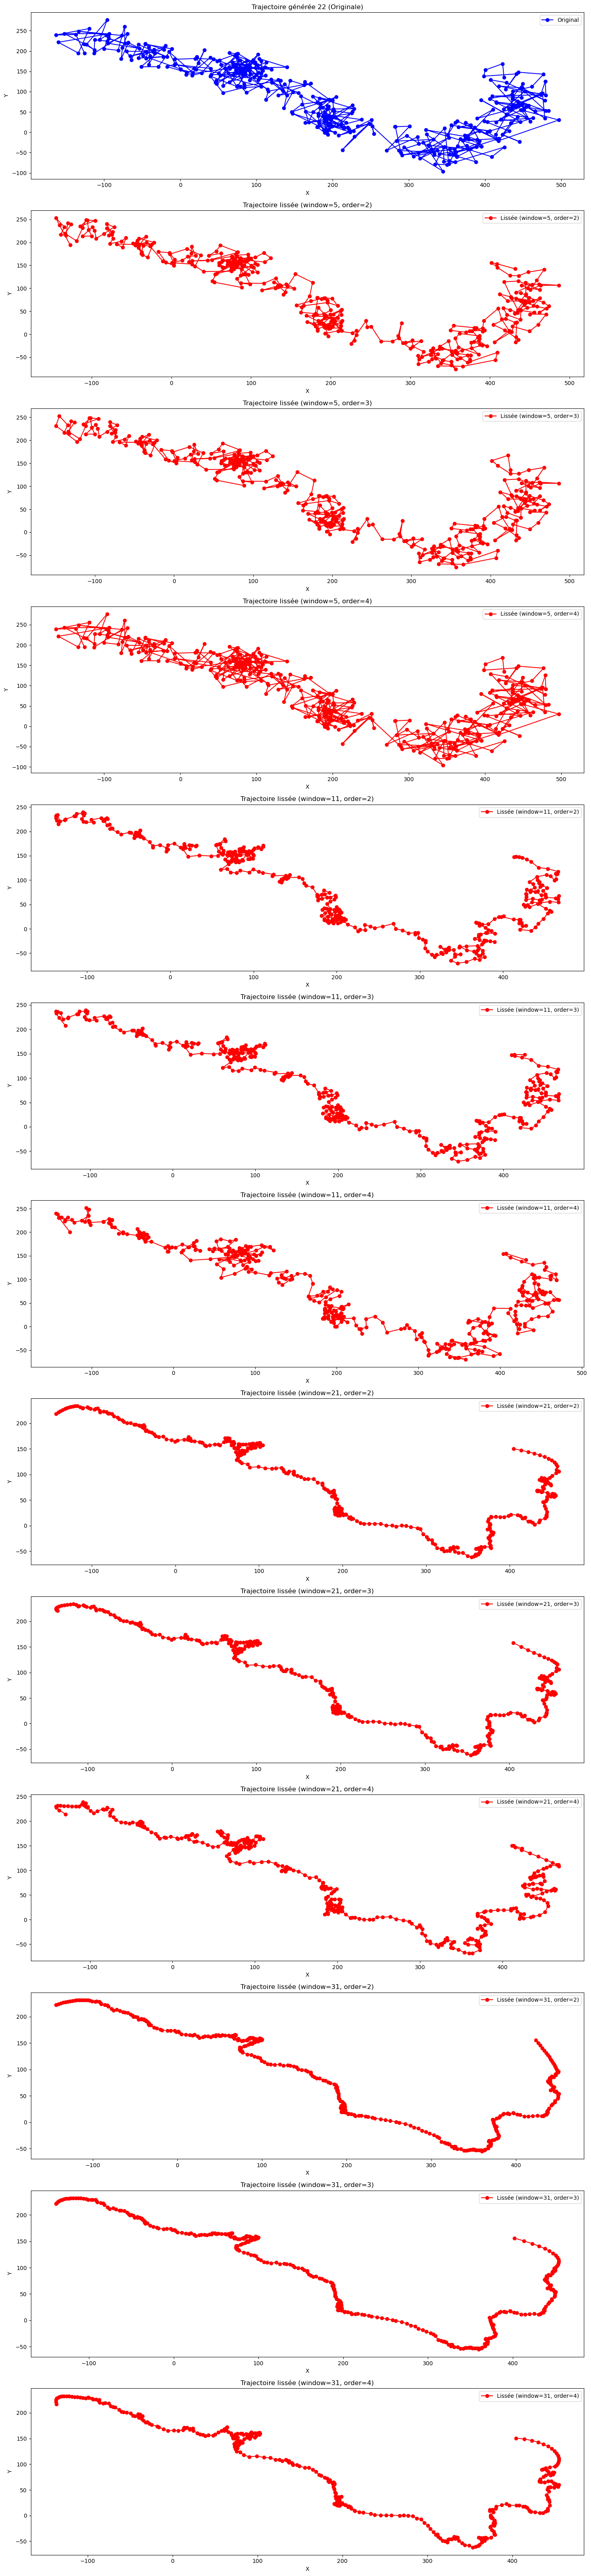

In [20]:
from scipy.signal import savgol_filter


def smoothen (values,
              window_size = 11,  
              poly_order = 3    
             ):
  return savgol_filter(values, window_size, poly_order)


example_index = np.random.choice(test_sample_size)
example_trajectory = generated[example_index]

# Paramètres à tester
window_sizes = [5, 11, 21, 31]  
poly_orders = [2, 3, 4]     

# Afficher la trajectoire originale et les versions lissées
plt.figure(figsize=(15, 5 * (len(window_sizes) * len(poly_orders) + 1)))

# Tracer la trajectoire originale
plt.subplot(len(window_sizes) * len(poly_orders) + 1, 1, 1)
plt.plot(example_trajectory[:, 0], example_trajectory[:, 1], 'b-o', label='Original')
plt.title(f'Trajectoire générée {example_index + 1} (Originale)')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

# Tester les paramètres de lissage
plot_index = 2 
for window_size in window_sizes:
    for poly_order in poly_orders:
        smoothed_x = smoothen(example_trajectory[:, 0], window_size, poly_order)
        smoothed_y = smoothen(example_trajectory[:, 1], window_size, poly_order)
        plt.subplot(len(window_sizes) * len(poly_orders) + 1, 1, plot_index)
        plt.plot(smoothed_x, smoothed_y, 'r-o', label=f'Lissée (window={window_size}, order={poly_order})')
        plt.title(f'Trajectoire lissée (window={window_size}, order={poly_order})')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()
        plot_index += 1
plt.tight_layout()
plt.show()




### Testing the reconstruction capabilities

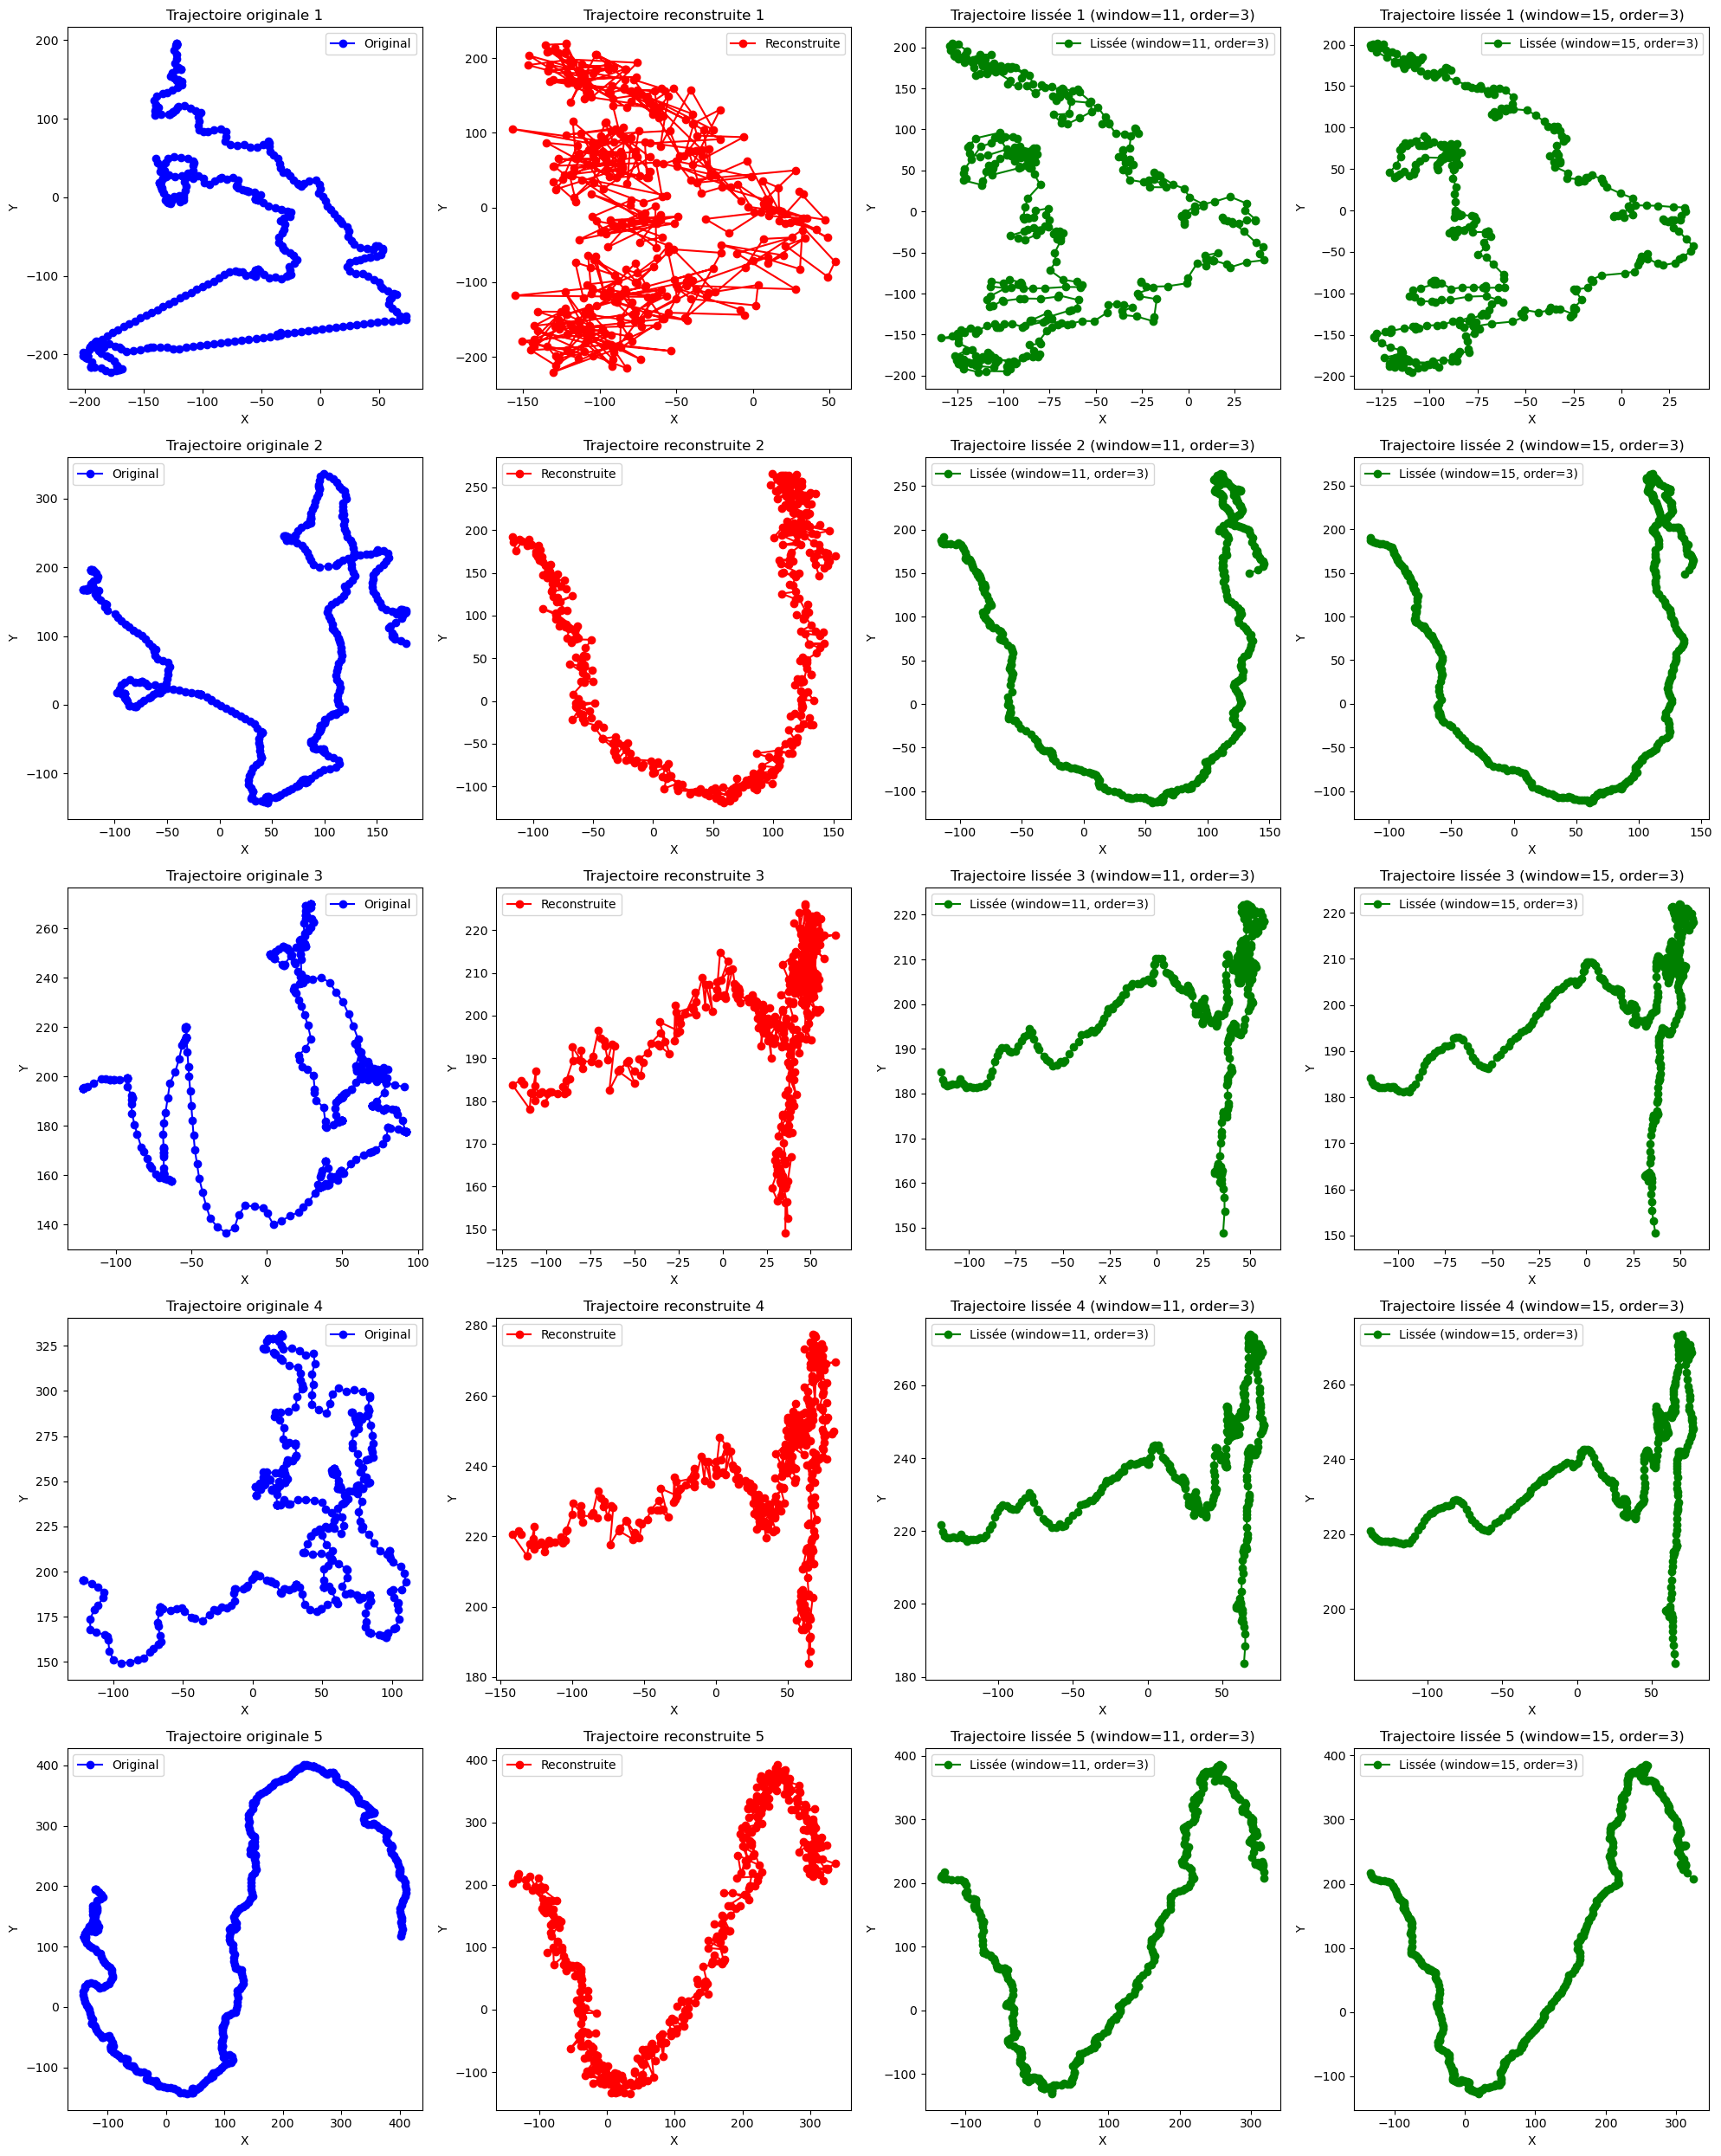

In [ ]:
num_samples = 5
random_indices = np.random.choice(len(dataset), size=num_samples, replace=False)

original_trajectories = []
reconstructed_trajectories = []

autoencoder.eval()  
with torch.no_grad():
    for idx in random_indices:
        # Récupérer la trajectoire originale
        original_traj = dataset[idx].numpy()
        original_trajectories.append(original_traj)
        
        x = dataset[idx].view(1, -1)  
        encoded = autoencoder.encoder(x.float())
        reconstructed = autoencoder.decoder(encoded).numpy().reshape(-1, 2)
        reconstructed_trajectories.append(reconstructed)

# We define the params of the smoothening
smooth_params = [
    {'window_size': 11, 'poly_order': 3},  # Premier jeu de paramètres
    {'window_size': 15, 'poly_order': 3}   # Deuxième jeu de paramètres
]


plt.figure(figsize=(20, 5 * num_samples))  
for i in range(num_samples):
    plt.subplot(num_samples, 4, 4 * i + 1)
    plt.plot(original_trajectories[i][:, 0], original_trajectories[i][:, 1], 'b-o', label='Original')
    plt.title(f'Trajectoire originale {i+1}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    
    # Trajectoire reconstruite
    plt.subplot(num_samples, 4, 4 * i + 2)
    plt.plot(reconstructed_trajectories[i][:, 0], reconstructed_trajectories[i][:, 1], 'r-o', label='Reconstruite')
    plt.title(f'Trajectoire reconstruite {i+1}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    
    # Trajectoires lissées
    for j, params in enumerate(smooth_params):
        # Appliquer le lissage
        smoothed_x = smoothen(reconstructed_trajectories[i][:, 0], params['window_size'], params['poly_order'])
        smoothed_y = smoothen(reconstructed_trajectories[i][:, 1], params['window_size'], params['poly_order'])
        
        # Tracer la trajectoire lissée
        plt.subplot(num_samples, 4, 4 * i + 3 + j)
        plt.plot(smoothed_x, smoothed_y, 'g-o', label=f'Lissée (window={params["window_size"]}, order={params["poly_order"]})')
        plt.title(f'Trajectoire lissée {i+1} (window={params["window_size"]}, order={params["poly_order"]})')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()

plt.tight_layout()
plt.show()


## Generate trajectories on each specific dataset

/home/ensta/ensta-kupecek/.conda/envs/wildgraph/lib/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/ensta/ensta-kupecek/.conda/envs/wildgraph/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ensta/ensta-kupecek/.conda/envs/wildgraph/lib/ ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 25.7 K | train
1 | decoder | Sequential | 26.5 K | train
-----------------------------------------------
52.3 K    Trainable params
0         Non-trainable params
52.3 K    Total params
0.209     Total estimated model params 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


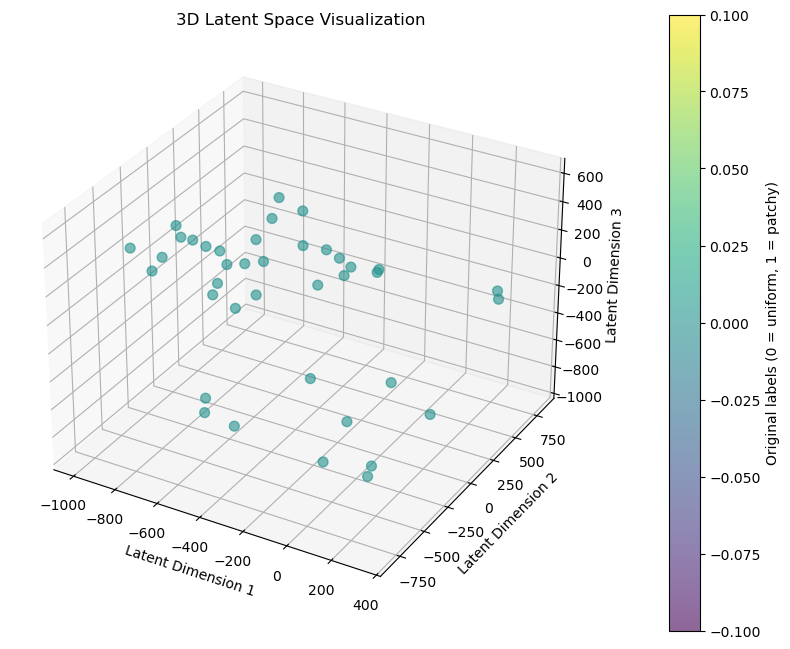

Generated trajectories saved to ./vae_experiments/generated_trajectories.npy


In [ ]:
file_path = "merged.csv"  # Update this path to your dataset
df = load_data(file_path)
df = df[df['label'] == 0] # Filter only uniform maps trajectories
#df = df[df['label'] == 1] # Filter only patchy maps trajectories



    # Initialize the VAE runner
seq_len = 400  
test_sample_size = 39  # We try to generate as much samples as we have in the original dataset
runner_final = VAERunner(seq_len, test_sample_size)

    # Run the VAE
encoded_data, original_labels, _, dataset, autoencoder = runner_final.run_vae(df, df, epochs=50)

    # Visualize the latent space
plot_latent_space(encoded_data, original_labels, reduce_dim=False)

    # Save the generated trajectories
save_dir = "./vae_experiments/"
os.makedirs(save_dir, exist_ok=True)
np.save(f"{save_dir}generated_trajectories_uniform.npy", generated)
#np.save(f"{save_dir}generated_trajectories_patchy.npy", generated)
#np.save(f"{save_dir}generated_trajectories_merged.npy", generated)

print(f"Generated trajectories saved to {save_dir}generated_trajectories.npy")


## Make and save reconstructions on uniform

In [ ]:
save_dir = "./reconstructed_trajectories/"
os.makedirs(save_dir, exist_ok=True)

# Passer en mode évaluation
autoencoder.eval()

# Initialiser les listes pour stocker les trajectoires originales et reconstruites
original_trajectories = []
reconstructed_trajectories = []

# Parcourir toutes les trajectoires
with torch.no_grad():
    for idx in range(len(dataset)):
        # Récupérer la trajectoire originale
        original_traj = dataset[idx].numpy()
        original_trajectories.append(original_traj)
        
        # Reconstruire la trajectoire
        x = dataset[idx].view(1, -1)  # Redimensionner pour le modèle
        encoded = autoencoder.encoder(x.float())
        reconstructed = autoencoder.decoder(encoded).numpy().reshape(-1, 2)
        reconstructed_trajectories.append(reconstructed)

# Associer les trajectoires à leurs ID originaux
# Supposons que les ID sont disponibles dans une liste `original_ids`
original_ids = [id_label[0] for id_label in df.groupby(['id', 'label']).groups.keys()]

# Sauvegarder toutes les trajectoires originales et reconstruites
for idx, (traj_id, original_traj, reconstructed_traj) in enumerate(zip(original_ids, original_trajectories, reconstructed_trajectories)):
    # Sauvegarder la trajectoire originale
    original_df = pd.DataFrame(original_traj, columns=['x', 'y'])
    original_df['id'] = traj_id  # Ajouter l'ID original
    original_save_path = f"{save_dir}original_trajectory_{traj_id}.csv"
    original_df.to_csv(original_save_path, index=False)
    print(f"Trajectoire originale {traj_id} sauvegardée à {original_save_path}")

    # Sauvegarder la trajectoire reconstruite
    reconstructed_df = pd.DataFrame(reconstructed_traj, columns=['x', 'y'])
    reconstructed_df['id'] = traj_id  # Ajouter l'ID original
    reconstructed_save_path = f"{save_dir}reconstructed_trajectory_{traj_id}.csv"
    reconstructed_df.to_csv(reconstructed_save_path, index=False)
    print(f"Trajectoire reconstruite {traj_id} sauvegardée à {reconstructed_save_path}")

print("Toutes les trajectoires originales et reconstruites ont été sauvegardées.")


Trajectoire 1 sauvegardée à ./reconstructed_trajectories/reconstructed_trajectory_1.csv
Trajectoire 2 sauvegardée à ./reconstructed_trajectories/reconstructed_trajectory_2.csv
Trajectoire 3 sauvegardée à ./reconstructed_trajectories/reconstructed_trajectory_3.csv
Trajectoire 4 sauvegardée à ./reconstructed_trajectories/reconstructed_trajectory_4.csv
Trajectoire 5 sauvegardée à ./reconstructed_trajectories/reconstructed_trajectory_5.csv
Trajectoire 6 sauvegardée à ./reconstructed_trajectories/reconstructed_trajectory_6.csv
Trajectoire 7 sauvegardée à ./reconstructed_trajectories/reconstructed_trajectory_7.csv
Trajectoire 8 sauvegardée à ./reconstructed_trajectories/reconstructed_trajectory_8.csv
Trajectoire 9 sauvegardée à ./reconstructed_trajectories/reconstructed_trajectory_9.csv
Trajectoire 10 sauvegardée à ./reconstructed_trajectories/reconstructed_trajectory_10.csv
Trajectoire 11 sauvegardée à ./reconstructed_trajectories/reconstructed_trajectory_11.csv
Trajectoire 12 sauvegardée à

## Test for best hyperparameters

/home/ensta/ensta-kupecek/.conda/envs/wildgraph/lib/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/ensta/ensta-kupecek/.conda/envs/wildgraph/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ensta/ensta-kupecek/.conda/envs/wildgraph/lib/ ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 12.8 K | train
1 | decoder | Sequential | 13.6 K | train
-----------------------------------------------
26.5 K    Trainable params
0         Non-trainable params
26.5 K    Total params
0.106     Total estimated model params 

Testing latent_dim=2, hidden_dim=16


/home/ensta/ensta-kupecek/.conda/envs/wildgraph/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


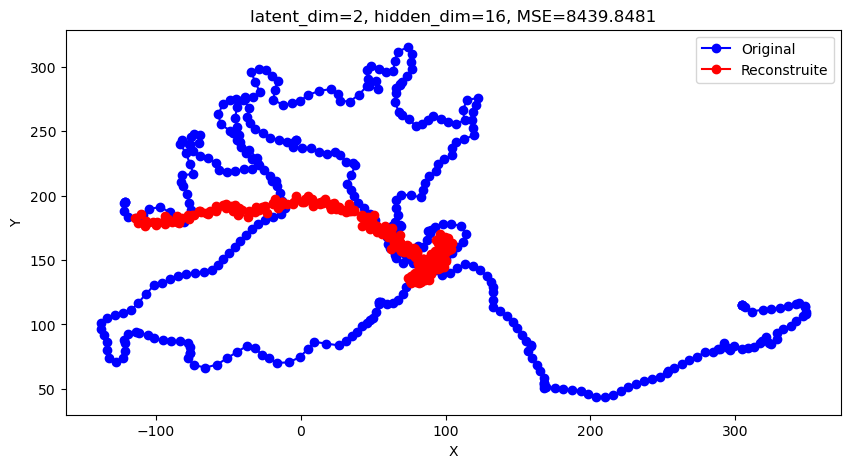

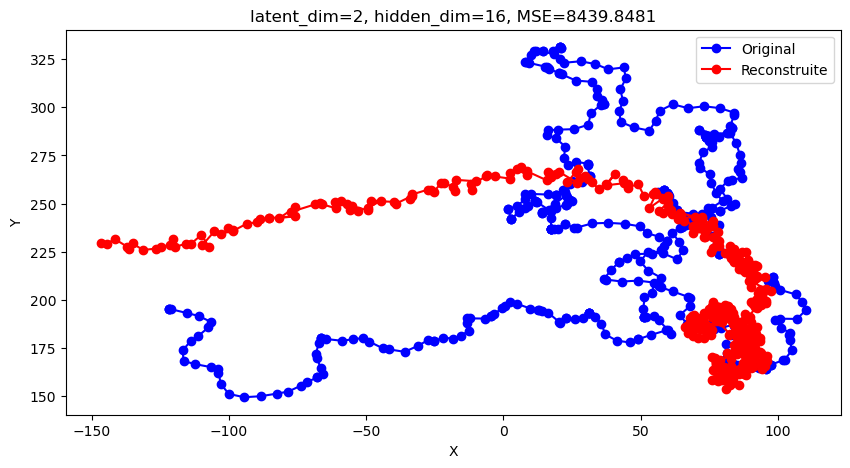

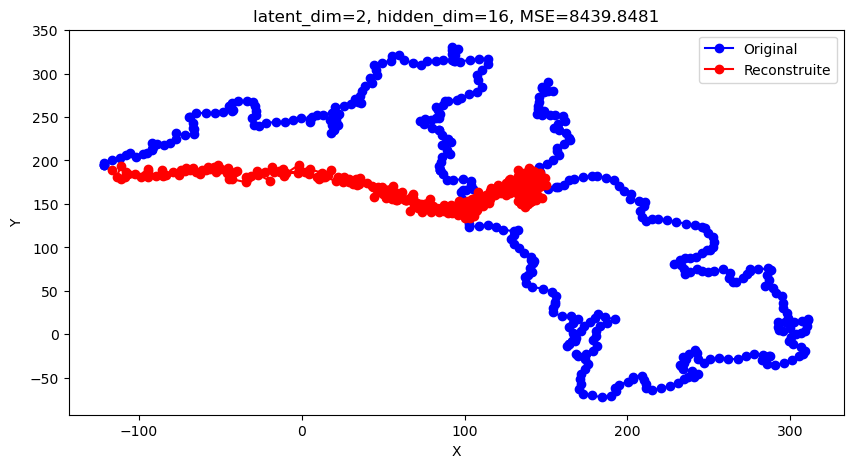

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 25.7 K | train
1 | decoder | Sequential | 26.5 K | train
-----------------------------------------------
52.2 K    Trainable params
0         Non-trainable params
52.2 K    Total params
0.209     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Testing latent_dim=2, hidden_dim=32


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


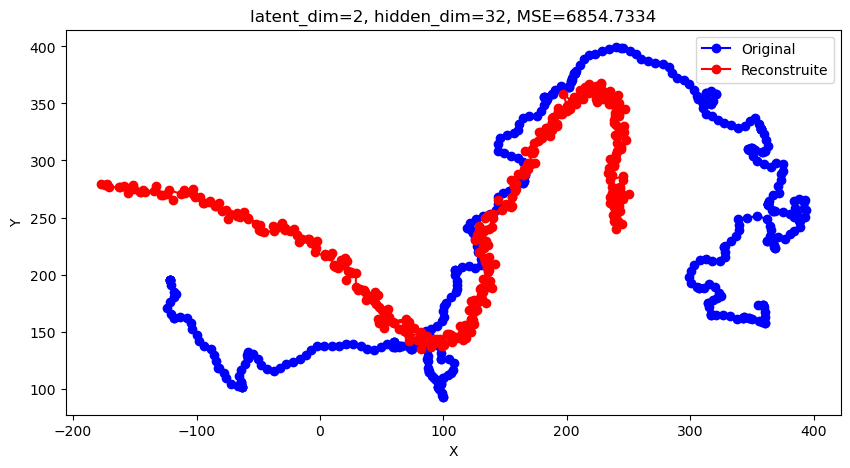

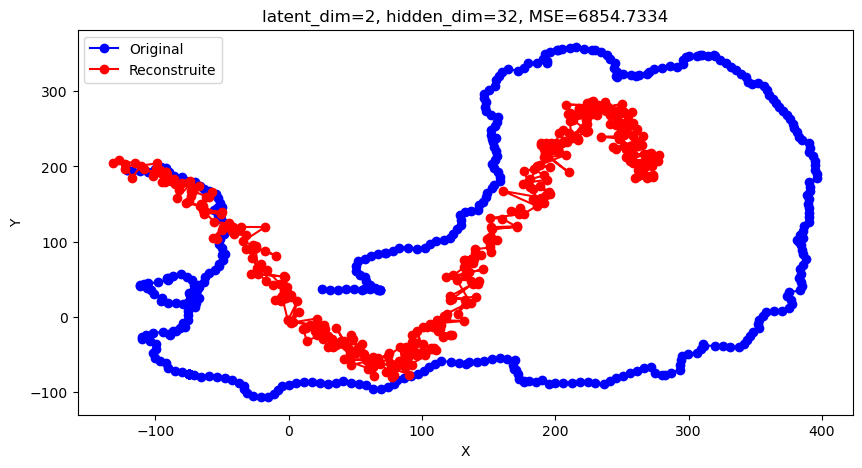

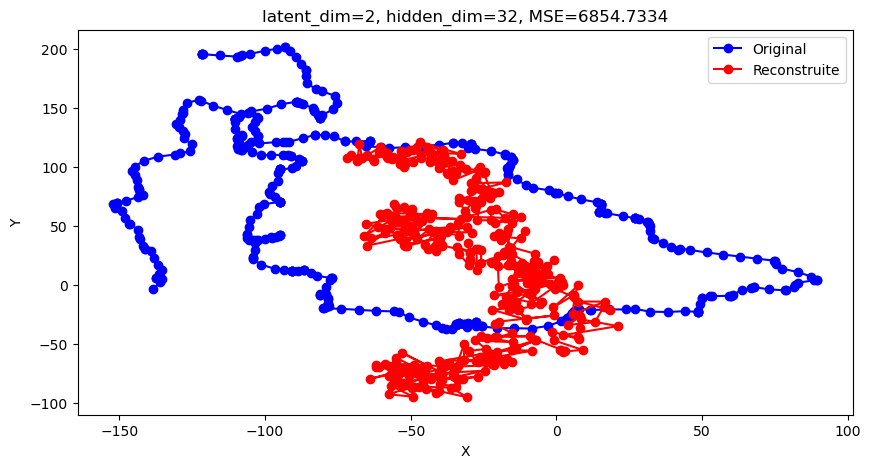

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 51.4 K | train
1 | decoder | Sequential | 52.2 K | train
-----------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.414     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Testing latent_dim=2, hidden_dim=64


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


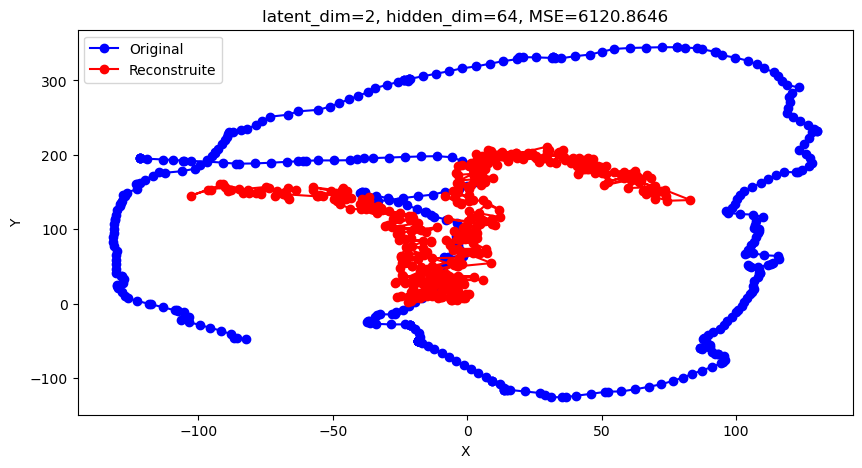

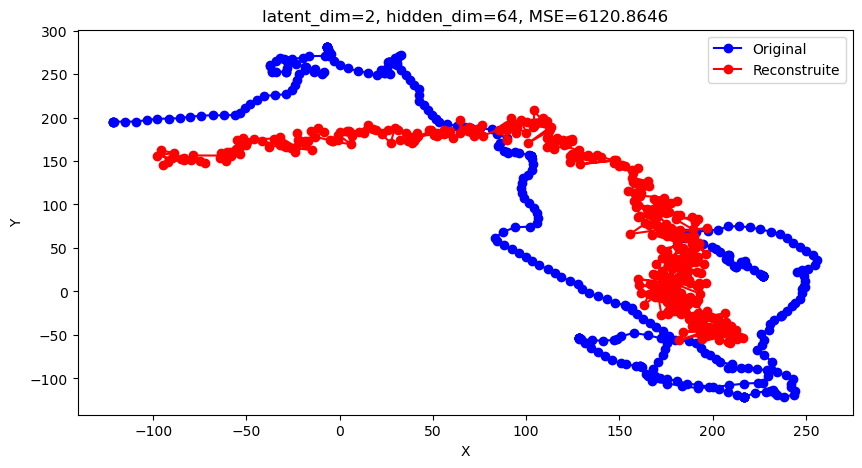

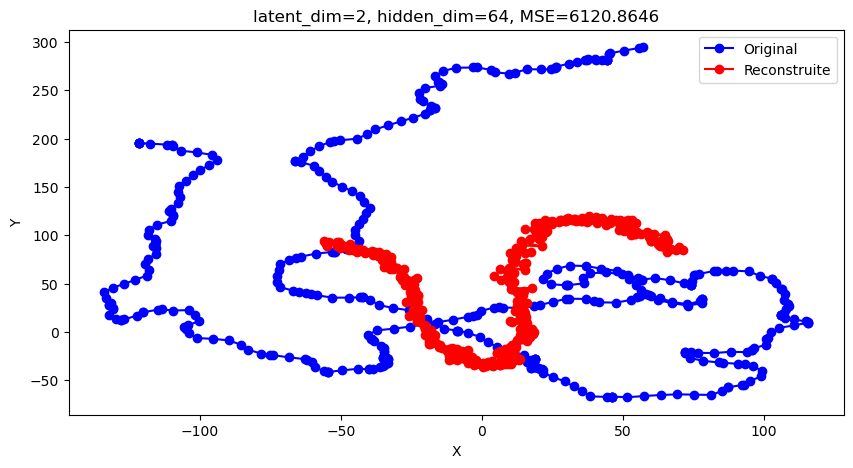

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 12.9 K | train
1 | decoder | Sequential | 13.7 K | train
-----------------------------------------------
26.5 K    Trainable params
0         Non-trainable params
26.5 K    Total params
0.106     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Testing latent_dim=3, hidden_dim=16


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


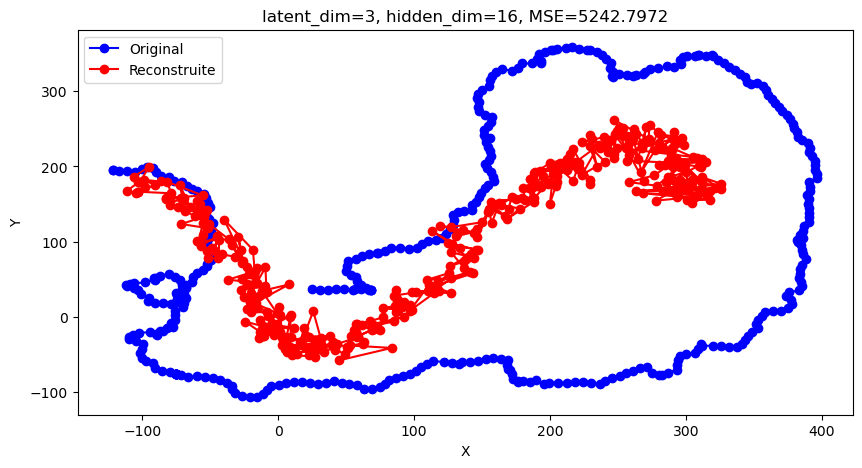

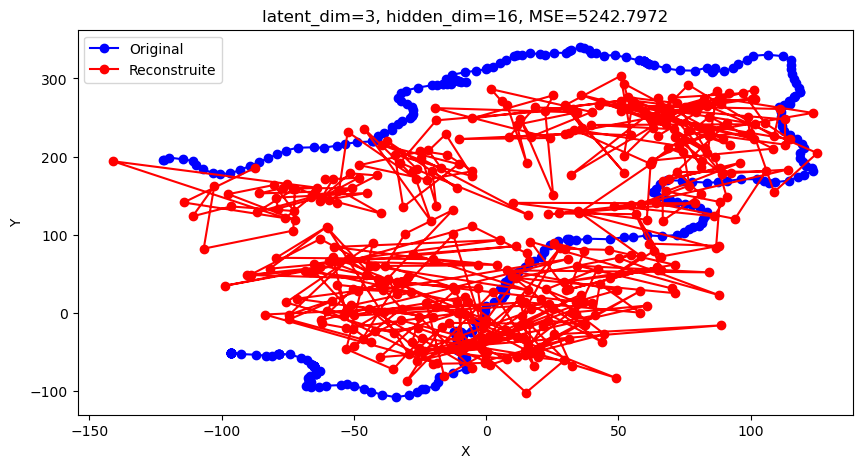

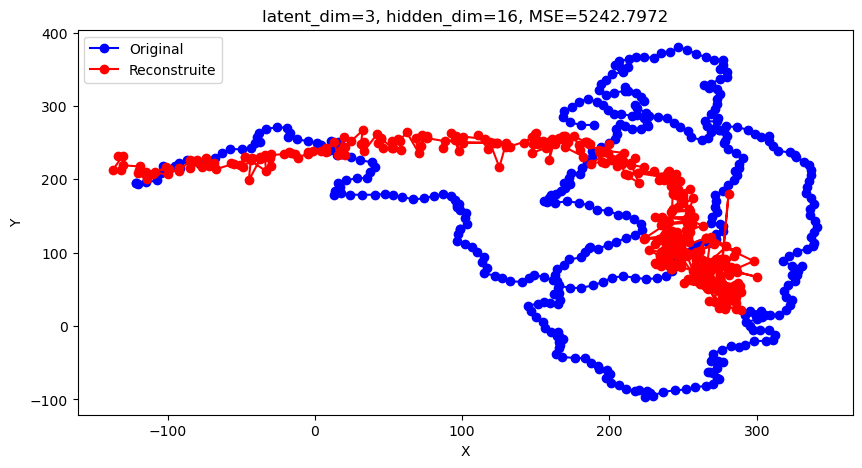

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 25.7 K | train
1 | decoder | Sequential | 26.5 K | train
-----------------------------------------------
52.3 K    Trainable params
0         Non-trainable params
52.3 K    Total params
0.209     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Testing latent_dim=3, hidden_dim=32


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


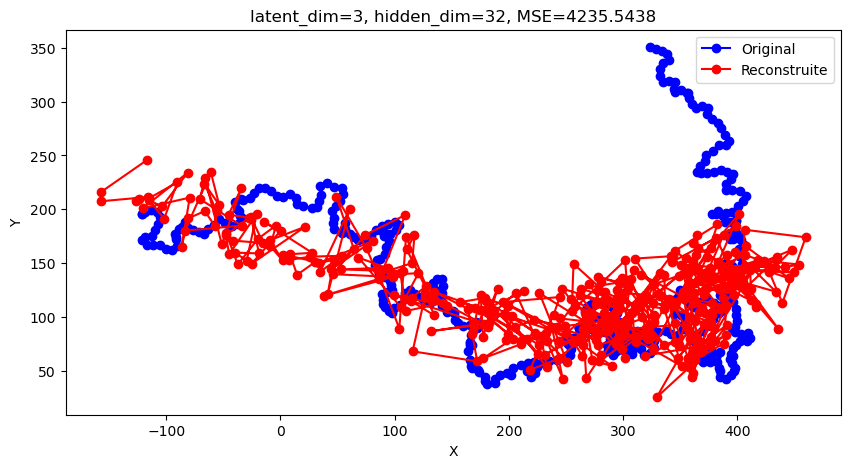

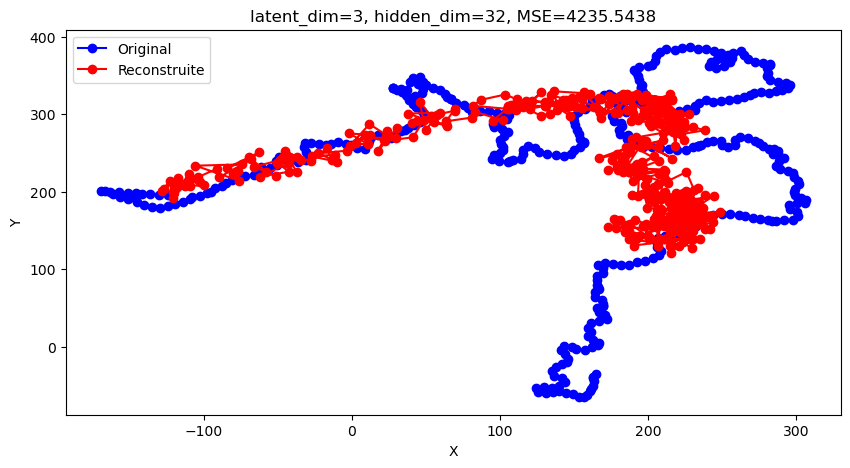

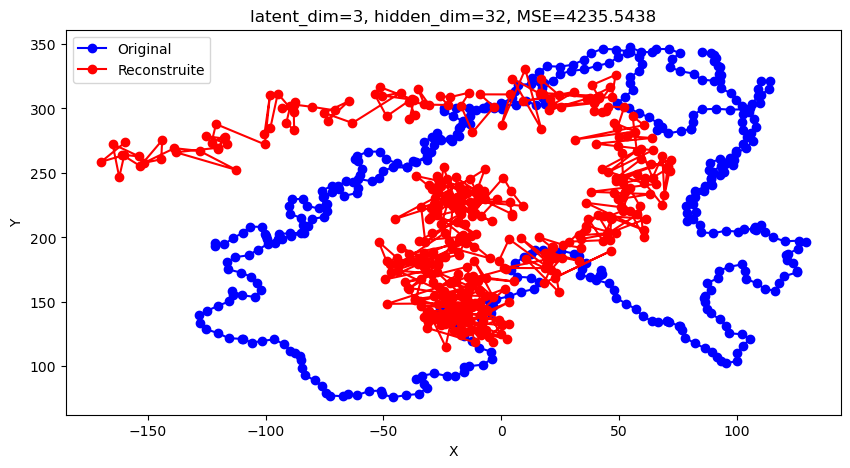

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 51.5 K | train
1 | decoder | Sequential | 52.3 K | train
-----------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.415     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Testing latent_dim=3, hidden_dim=64


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


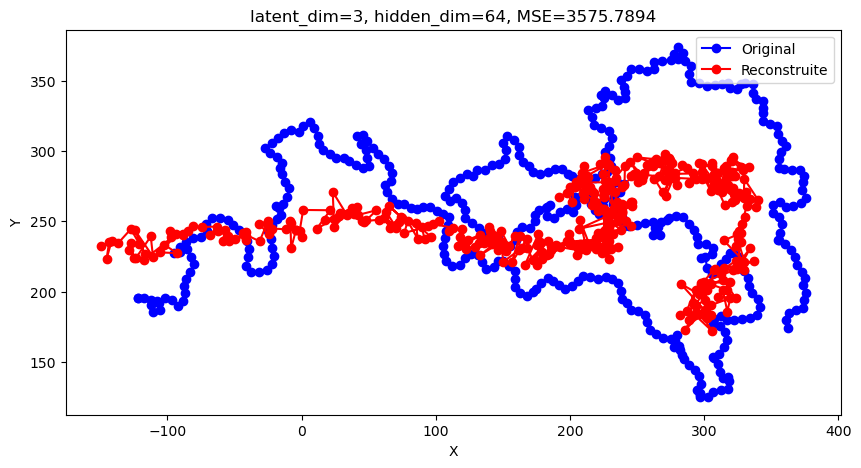

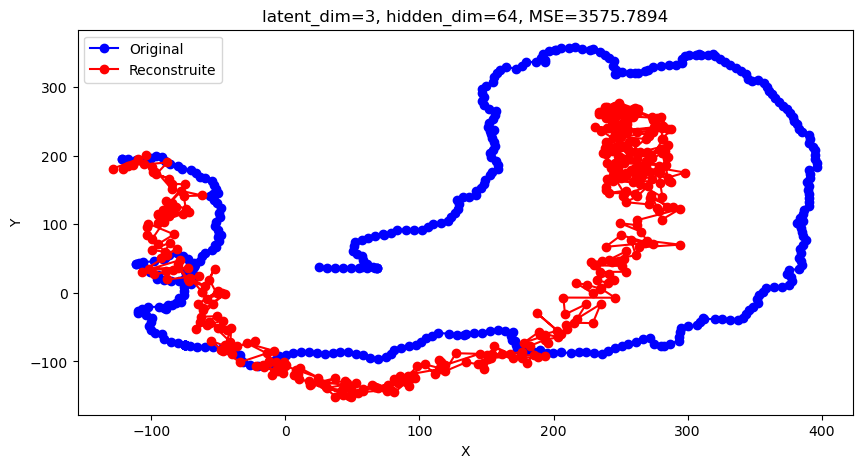

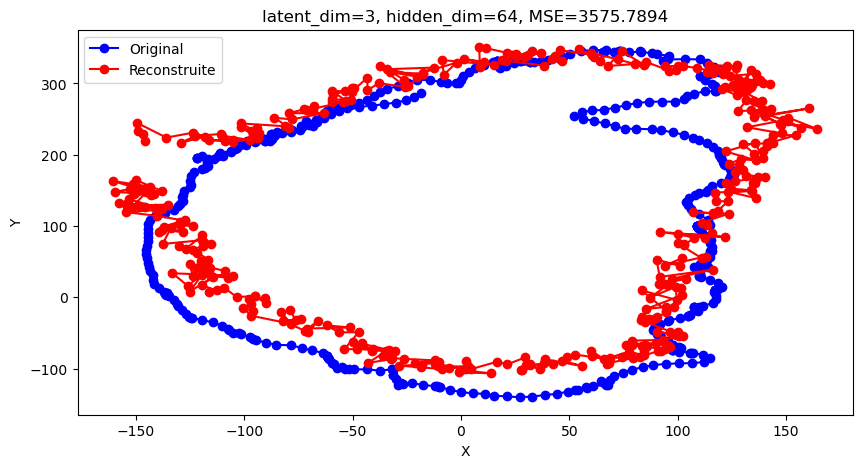

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 12.9 K | train
1 | decoder | Sequential | 13.7 K | train
-----------------------------------------------
26.6 K    Trainable params
0         Non-trainable params
26.6 K    Total params
0.106     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Testing latent_dim=5, hidden_dim=16


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


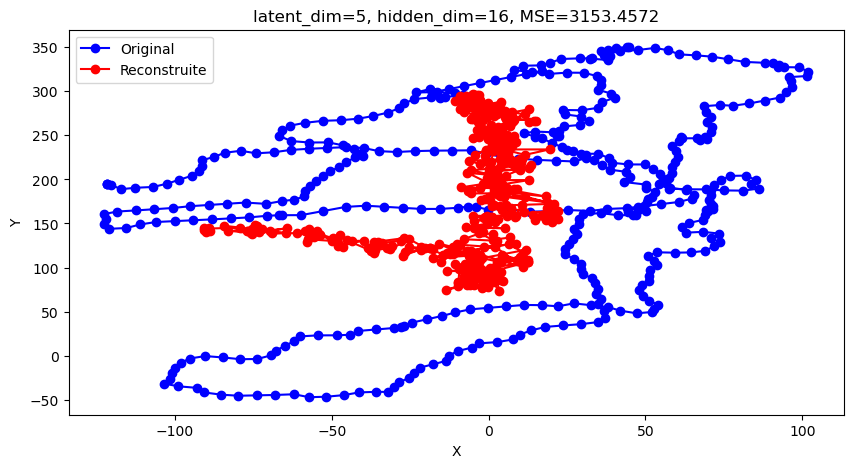

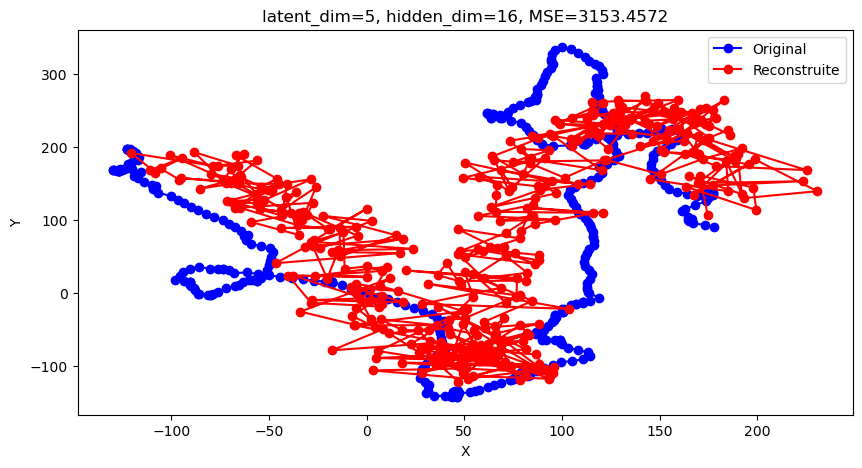

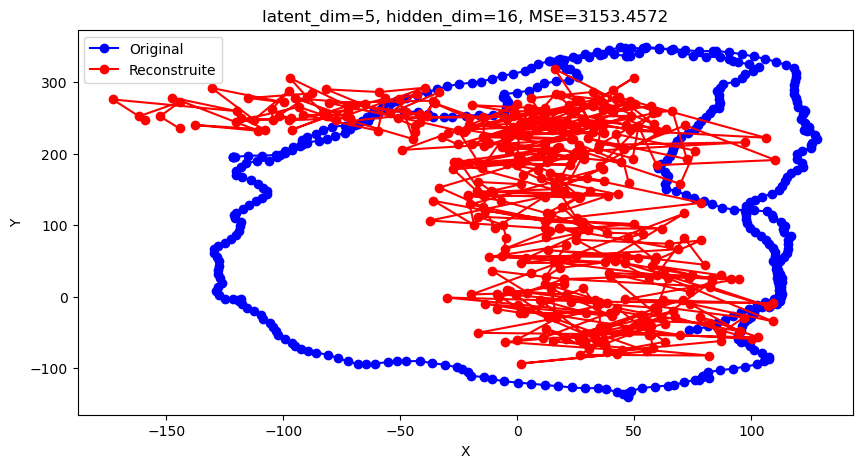

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 25.8 K | train
1 | decoder | Sequential | 26.6 K | train
-----------------------------------------------
52.4 K    Trainable params
0         Non-trainable params
52.4 K    Total params
0.210     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Testing latent_dim=5, hidden_dim=32


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


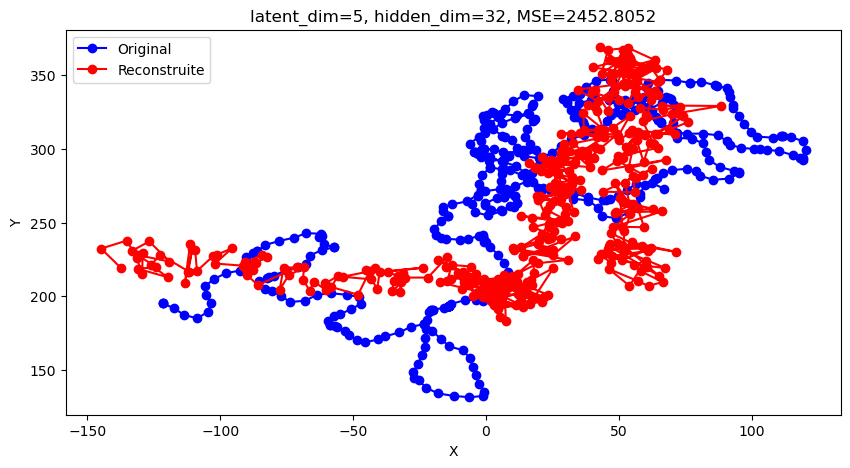

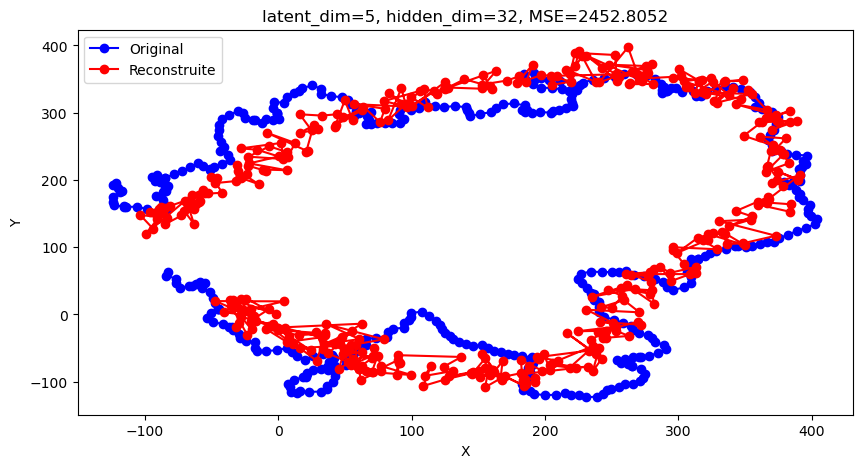

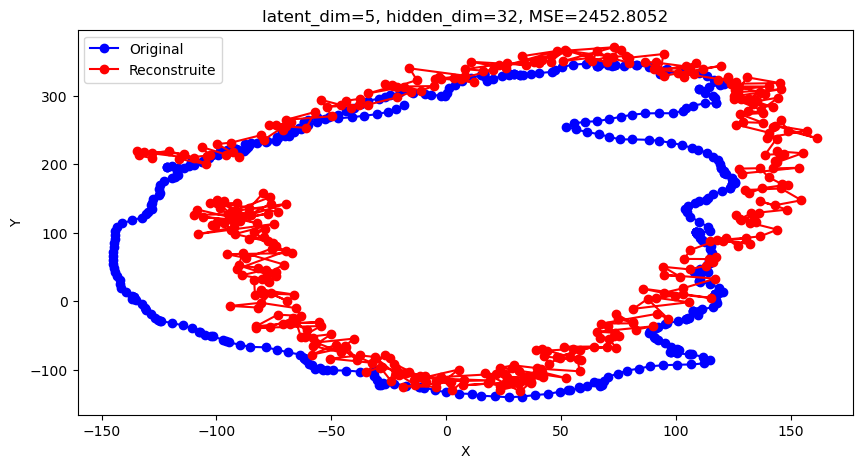

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 51.6 K | train
1 | decoder | Sequential | 52.4 K | train
-----------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.416     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Testing latent_dim=5, hidden_dim=64


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


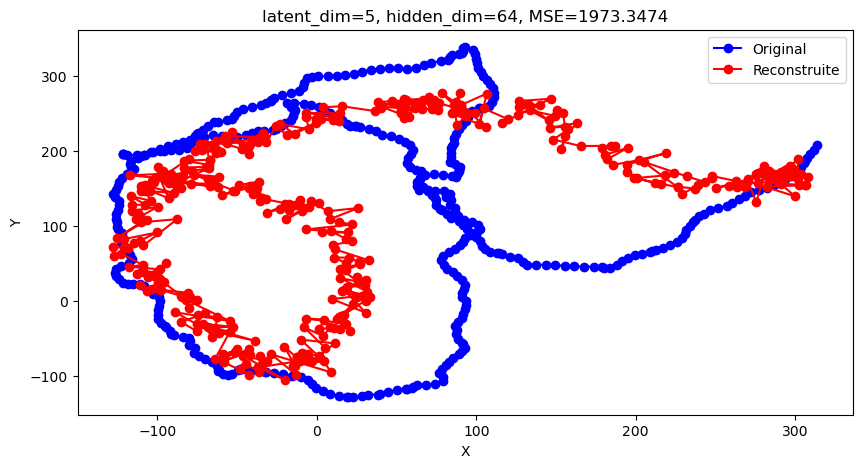

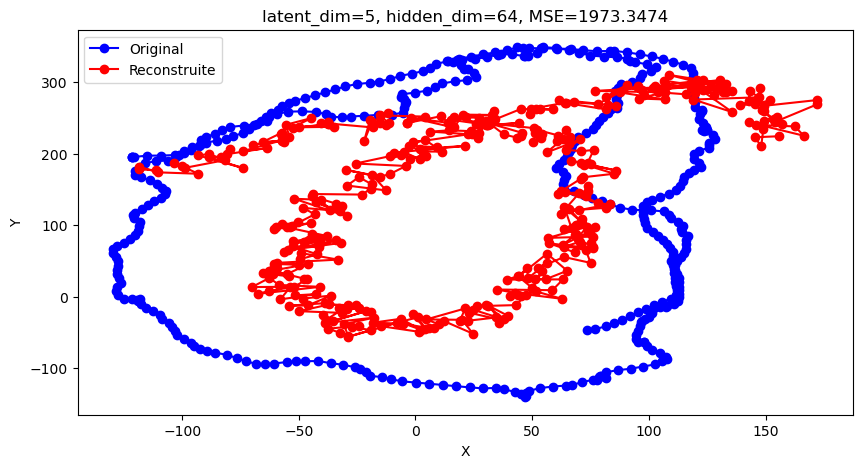

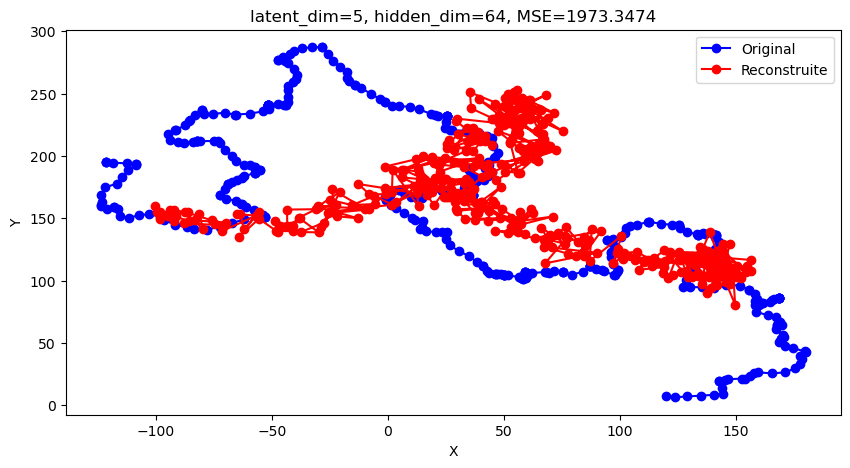

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 13.0 K | train
1 | decoder | Sequential | 13.8 K | train
-----------------------------------------------
26.8 K    Trainable params
0         Non-trainable params
26.8 K    Total params
0.107     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Testing latent_dim=10, hidden_dim=16


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


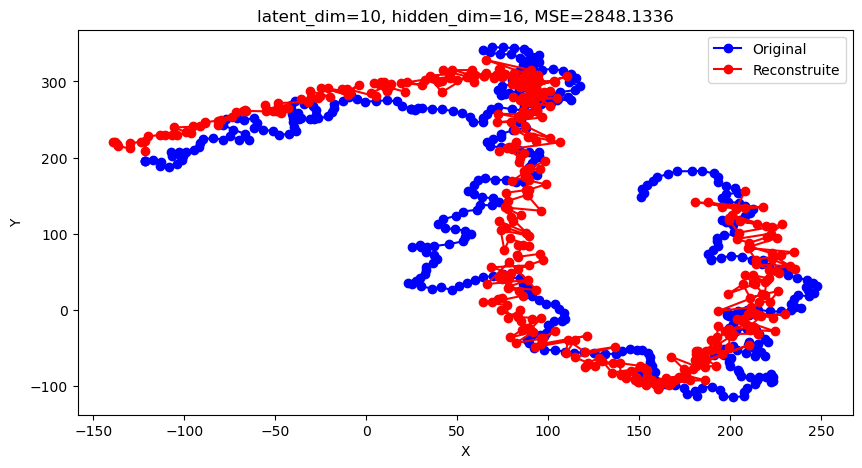

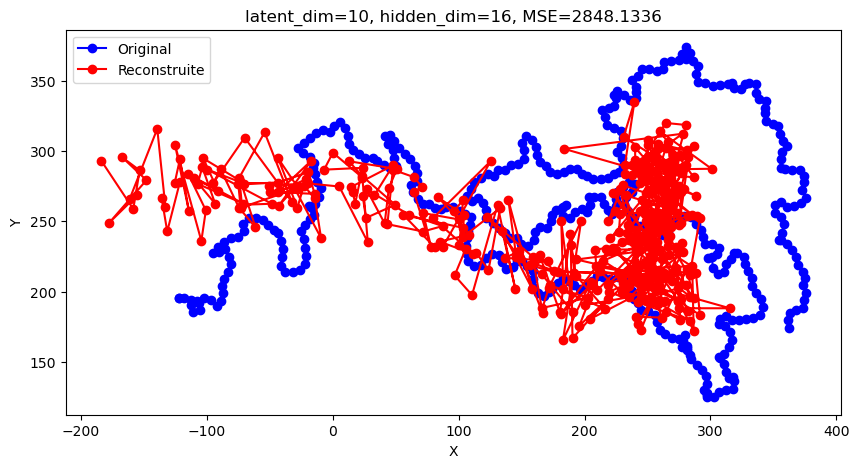

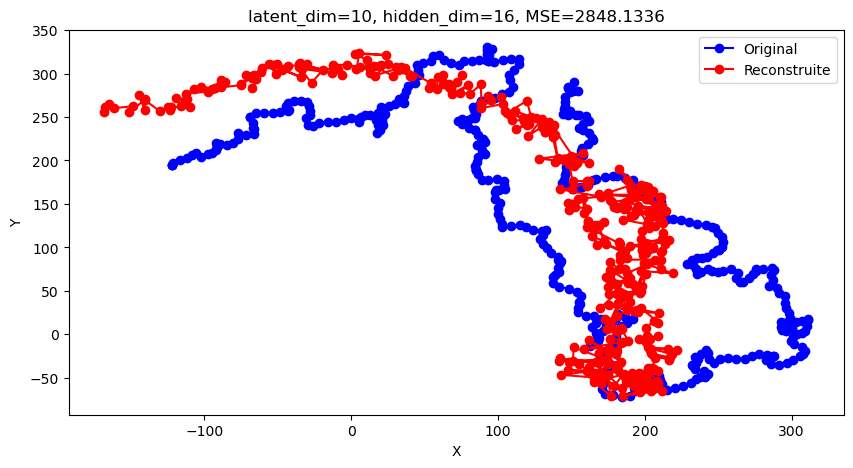

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 26.0 K | train
1 | decoder | Sequential | 26.8 K | train
-----------------------------------------------
52.7 K    Trainable params
0         Non-trainable params
52.7 K    Total params
0.211     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Testing latent_dim=10, hidden_dim=32


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


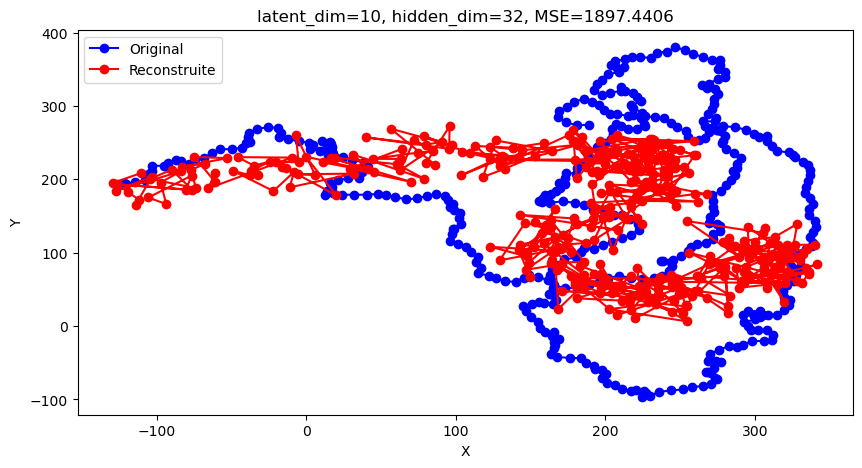

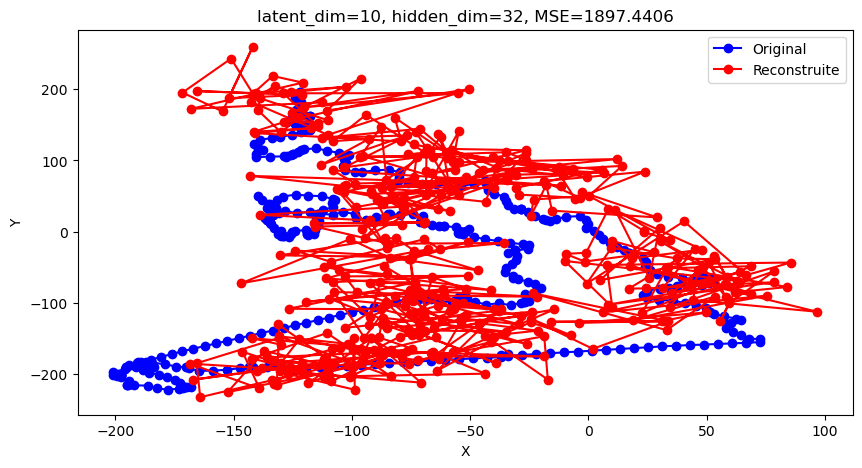

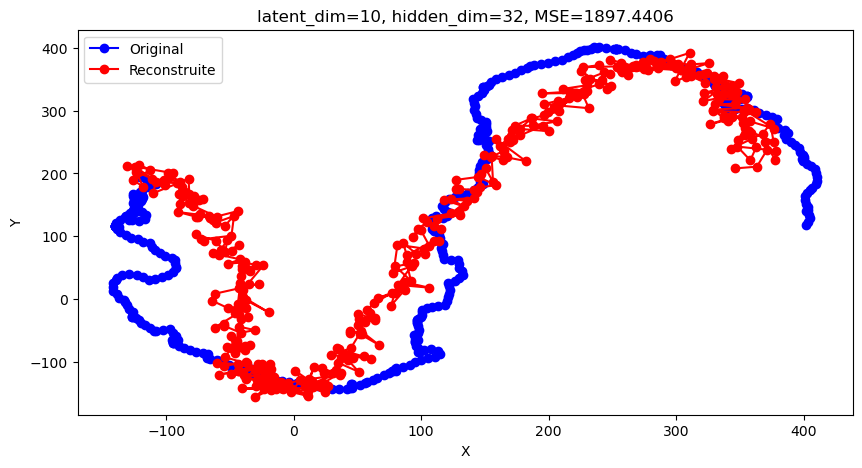

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 51.9 K | train
1 | decoder | Sequential | 52.7 K | train
-----------------------------------------------
104 K     Trainable params
0         Non-trainable params
104 K     Total params
0.418     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Testing latent_dim=10, hidden_dim=64


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


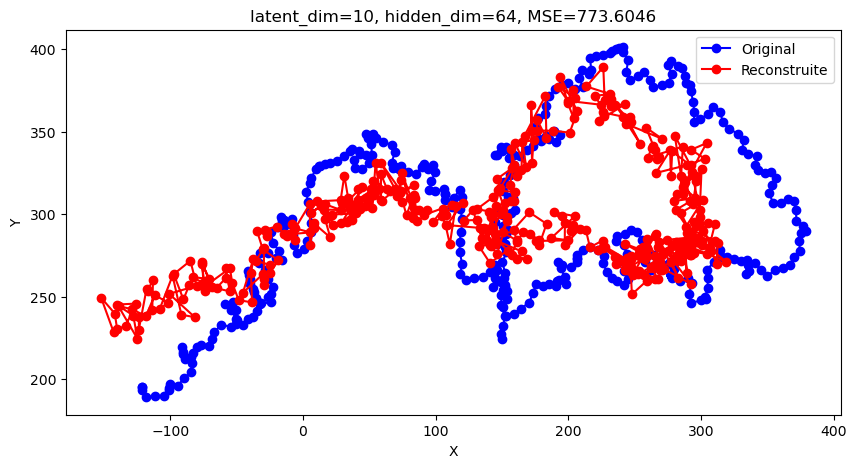

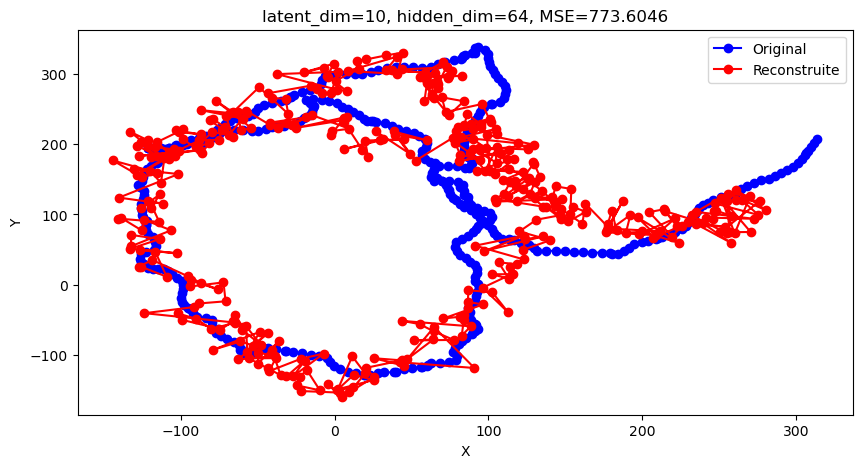

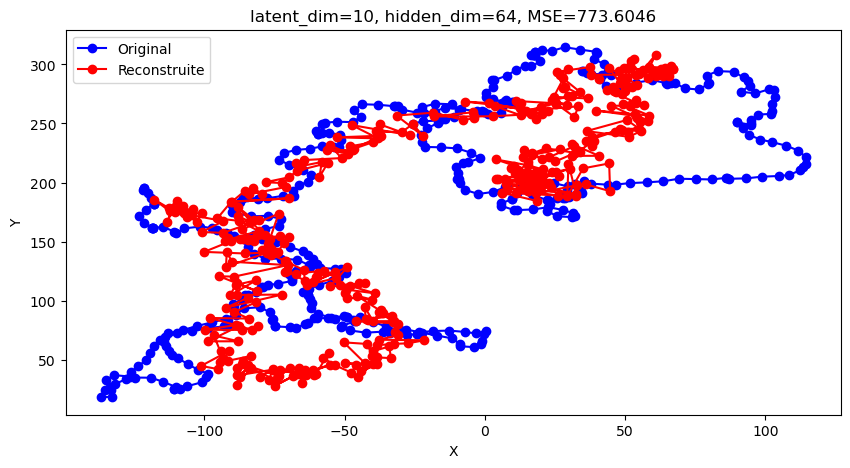


Results:
latent_dim=2, hidden_dim=16, MSE=8439.8481
latent_dim=2, hidden_dim=32, MSE=6854.7334
latent_dim=2, hidden_dim=64, MSE=6120.8646
latent_dim=3, hidden_dim=16, MSE=5242.7972
latent_dim=3, hidden_dim=32, MSE=4235.5438
latent_dim=3, hidden_dim=64, MSE=3575.7894
latent_dim=5, hidden_dim=16, MSE=3153.4572
latent_dim=5, hidden_dim=32, MSE=2452.8052
latent_dim=5, hidden_dim=64, MSE=1973.3474
latent_dim=10, hidden_dim=16, MSE=2848.1336
latent_dim=10, hidden_dim=32, MSE=1897.4406
latent_dim=10, hidden_dim=64, MSE=773.6046


In [ ]:

class VAEDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx]).float()
class LitAutoEncoder(L.LightningModule):
    def __init__(self, input_dim, latent_dim, hidden_dim=64):
        super().__init__()
        # Encodeur
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        # Décodeur
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat
    
    def training_step(self, batch, batch_idx):
        x = batch.view(batch.size(0), -1)  # Aplatir les trajectoires
        x_hat = self(x)
        loss = nn.functional.mse_loss(x_hat, x)
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

def prepare_data(df, seq_len):
    grouped = df.groupby(['id', 'label'])
    group_arrays = [group[['x', 'y']].to_numpy() for _, group in grouped]
    train_array = np.array([pad_or_truncate(traj, seq_len) for traj in group_arrays])
    return train_array


# Fonction pour visualiser les trajectoires originales et reconstruites
def plot_reconstructions(original, reconstructed, title):
    plt.figure(figsize=(10, 5))
    plt.plot(original[:, 0], original[:, 1], 'b-o', label='Original')
    plt.plot(reconstructed[:, 0], reconstructed[:, 1], 'r-o', label='Reconstruite')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_and_evaluate(train_array, latent_dim, hidden_dim, epochs, csv_writer):
    dataset = VAEDataset(train_array)
    train_loader = DataLoader(dataset, batch_size=8, num_workers=8)
    
    input_dim = train_array.shape[1] * train_array.shape[2]  # seq_len * 2
    autoencoder = LitAutoEncoder(input_dim, latent_dim, hidden_dim)
    num_params = count_parameters(autoencoder)  # Compter le nombre de paramètres
    trainer = L.Trainer(max_epochs=epochs, devices=1)
    trainer.fit(autoencoder, train_loader)
    
    autoencoder.eval()
    with torch.no_grad():
        x = torch.tensor(train_array).view(train_array.shape[0], -1)
        x_hat = autoencoder(x.float()).numpy()
        mse = np.mean((x.numpy() - x_hat) ** 2)  # Calculer l'erreur MSE
    
    # Écrire les résultats dans le fichier CSV
    csv_writer.writerow([latent_dim, hidden_dim, num_params, mse])
    
    return mse, autoencoder

# Charger les données
file_path = "merged.csv"  
df = pd.read_csv(file_path, usecols=['id', 'x', 'y', 'label'])
seq_len = 400
train_array = prepare_data(df, seq_len)

# Hyperparamètres à tester
latent_dims = [2, 3, 5, 10]  # Dimensions de l'espace latent
hidden_dims = [16, 32, 64]   # Tailles des couches cachées
epochs = 50                   # Nombre d'époch 

results_file = "vae_results.csv"
with open(results_file, mode='w', newline='') as file:
    csv_writer = csv.writer(file)
    csv_writer.writerow(["latent_dim", "hidden_dim", "num_params", "mse"])
    
    # Boucle pour tester différentes configurations
    results = []
    for latent_dim in latent_dims:
        for hidden_dim in hidden_dims:
            print(f"Testing latent_dim={latent_dim}, hidden_dim={hidden_dim}")
            mse, autoencoder = train_and_evaluate(train_array, latent_dim, hidden_dim, epochs, csv_writer)
            results.append((latent_dim, hidden_dim, mse))
            
            autoencoder.eval()
            with torch.no_grad():
                sample_idx = np.random.choice(len(train_array), size=3, replace=False)
                for idx in sample_idx:
                    original = train_array[idx]
                    x = torch.tensor(original).view(1, -1)
                    reconstructed = autoencoder(x.float()).numpy().reshape(-1, 2)
                    #Plot pour visualiser des reconstructions
                    plot_reconstructions(original, reconstructed, 
                                        f"latent_dim={latent_dim}, hidden_dim={hidden_dim}, MSE={mse:.4f}")

# Afficher les résultats
print("\nResults:")
for latent_dim, hidden_dim, mse in results:
    print(f"latent_dim={latent_dim}, hidden_dim={hidden_dim}, MSE={mse:.4f}")
